In [103]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
from tr import aggregation_function
from WeatherData import aggregation_functionWeather
import os
import sys
from datetime import datetime
from calendar import day_abbr, month_abbr, mdays
from scipy.stats import skew
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.utils import check_array
from scipy.stats import skew
import seaborn as sns
import numpy as np
import utils

In [67]:
#Dataframe with Greek Holidays
holidays_dict = {'ds': ['2019-01-01',"2019-01-06", "2019-03-25", "2019-04-26",  "2019-04-29", "2019-05-01", "2019-06-17", "2019-08-15", "2019-10-28", "2019-12-25", "2019-12-26"], 'holiday' : ["New Year's Day", "Epiphany", "Independence Day", "Orthodox Good Friday", "Orthodox Easter Monday", "Labour Day", "Orthodox Whit Monday", "Assumption", "Ochi Day", "Christmas Day", "Boxing Day"] }
holidays_data = pd.DataFrame.from_dict(holidays_dict)

In [68]:
holidays_data

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-06,Epiphany
2,2019-03-25,Independence Day
3,2019-04-26,Orthodox Good Friday
4,2019-04-29,Orthodox Easter Monday
5,2019-05-01,Labour Day
6,2019-06-17,Orthodox Whit Monday
7,2019-08-15,Assumption
8,2019-10-28,Ochi Day
9,2019-12-25,Christmas Day


In [69]:
#Aggregation function returns the data aggregated according to a value
data = aggregation_functionTomTom(1440)
data

,timestamp,cs_Gate 10A - Entry,cs_Gate 10A - Exit,cs_Gate 16 - Entrance,cs_Gate 16 - Exit
0,2018-04-28,164.0,139.0,416.0,423.0
1,2018-04-29,88.0,76.0,381.0,389.0
2,2018-04-30,707.0,663.0,258.0,293.0
3,2018-05-01,40.0,40.0,9.0,20.0
4,2018-05-02,604.0,568.0,430.0,456.0
...,...,...,...,...,...
643,2020-01-31,980.0,882.0,730.0,832.0
644,2020-02-01,249.0,217.0,296.0,325.0
645,2020-02-02,153.0,159.0,13.0,23.0
646,2020-02-03,1021.0,914.0,762.0,865.0


In [70]:
#We only work with one location at a time
i = 1
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['volume'] = data.iloc[:, i]
df

,timestamp,volume
0,2018-04-28,164.0
1,2018-04-29,88.0
2,2018-04-30,707.0
3,2018-05-01,40.0
4,2018-05-02,604.0
...,...,...
643,2020-01-31,980.0
644,2020-02-01,249.0
645,2020-02-02,153.0
646,2020-02-03,1021.0


In [71]:
df = df.set_index('timestamp')

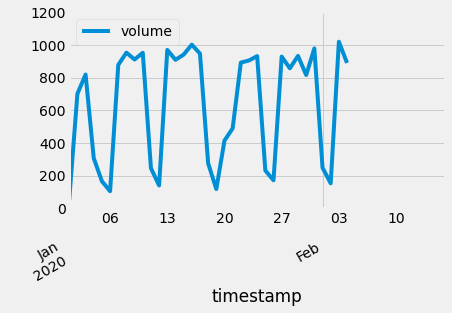

In [72]:
pd.plotting.register_matplotlib_converters()
df.plot()
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),0,1200])
plt.gcf().autofmt_xdate()
plt.show()


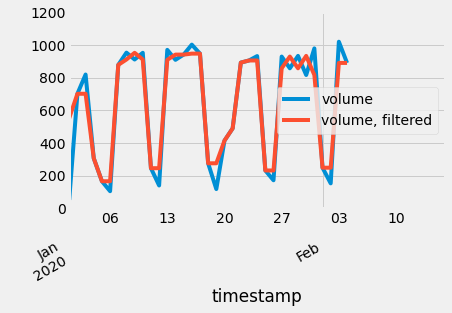

In [73]:
import utils
import scipy
from scipy.signal import medfilt
dfc = df.copy()
dfc.loc[:, 'volume, filtered'] = medfilt(dfc['volume'])
dfc.plot()
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),0,1200])
plt.gcf().autofmt_xdate()
plt.show()


In [74]:
dfc.isnull().sum()

volume              0
volume, filtered    0
dtype: int64

In [75]:
df[df.isna().any(axis = 1)]

,volume
timestamp,


In [31]:
current_speed = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).mean()
q25 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.25)
q75 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.75)

In [76]:
ndays_m = mdays.copy()
ndays_m[2] = 29

Text(0.5, 1.0, 'Volume')

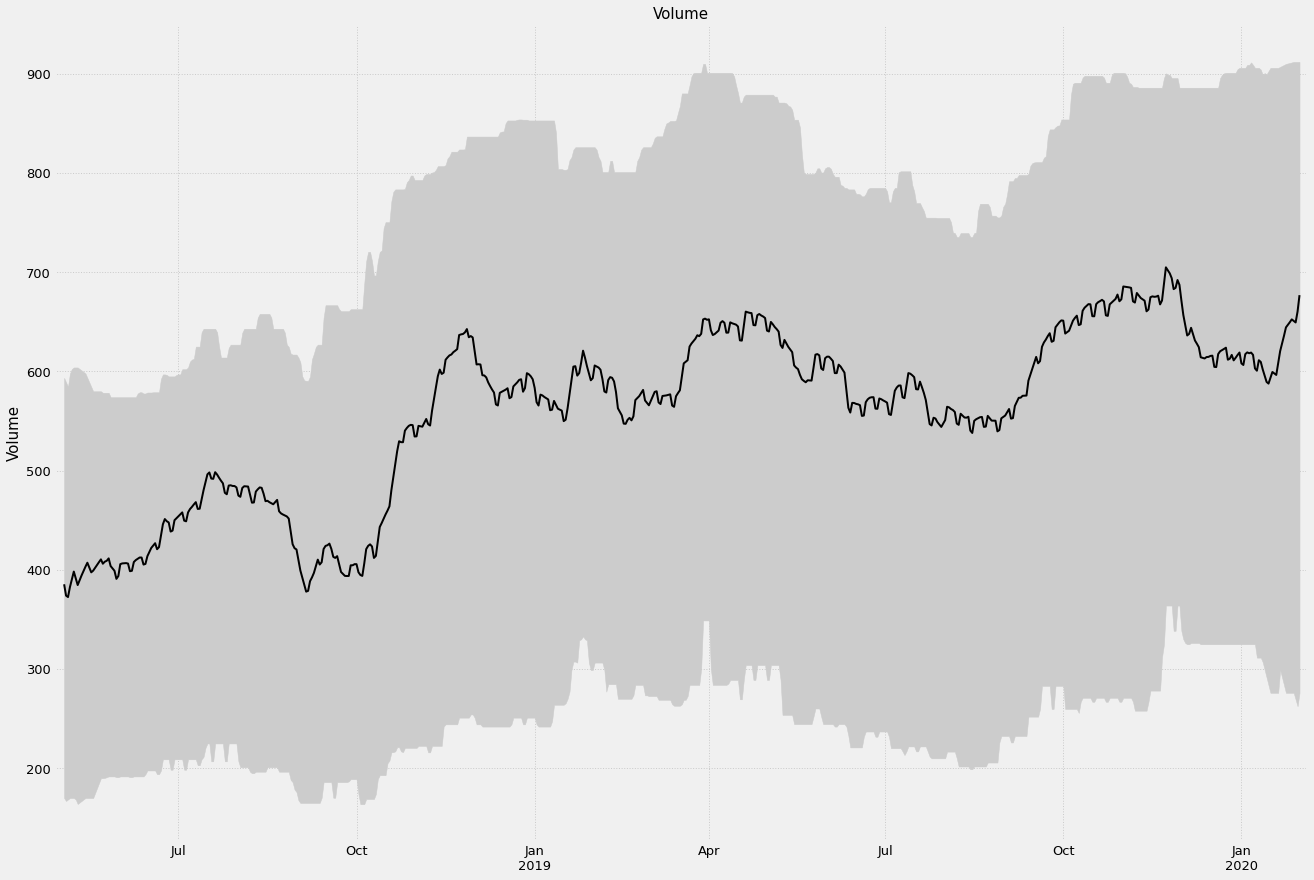

In [77]:
f, ax = plt.subplots(figsize=(20,14)) 

current_speed.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(current_speed.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

#ax.set_xticks(ndays_m)
#ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('Volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Volume', fontsize=15)

In [78]:
hour_week = dfc.loc[:, ['volume, filtered']].copy()
hour_week.loc[:, 'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour
hour_week = hour_week.groupby(['day_of_week', 'hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)

In [79]:
hour_week

hour,0
day_of_week,
0,647.827957
1,725.688172
2,720.739130
3,737.021739
4,672.076087
5,208.096774
6,203.827957


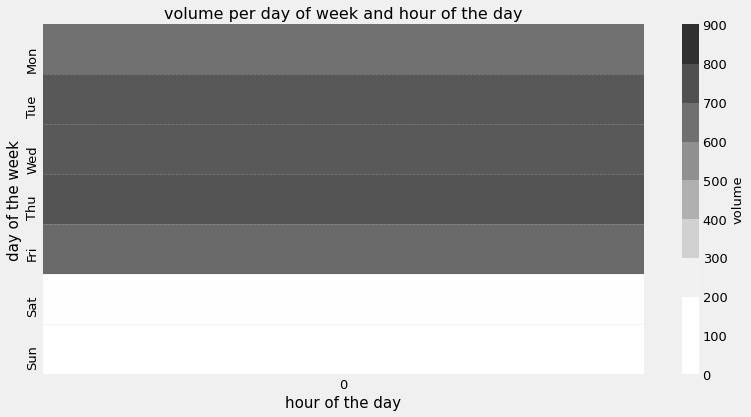

In [80]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=1000, cbar_kws={'boundaries':np.arange(0,1000,100)})
cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('volume', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('volume per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

In [81]:
weekdays = dfc.loc[dfc.index.strftime('%A').isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'volume, filtered']
weekends = dfc.loc[dfc.index.strftime('%A').isin(['Saturda', 'Sunday']), 'volume, filtered']
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

Text(0.5, 1.0, 'current volume per hour of the day')

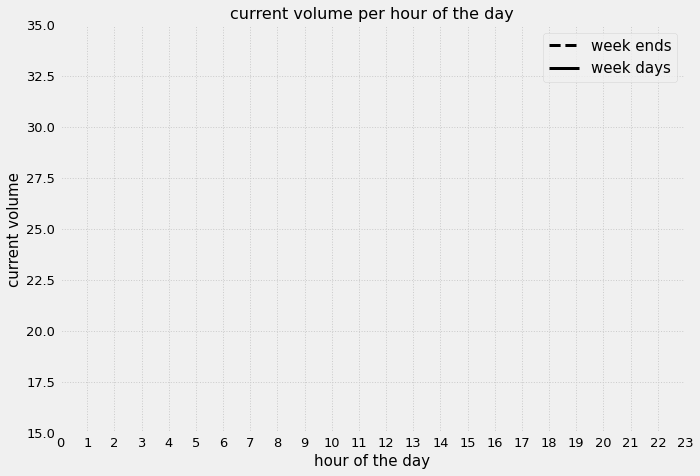

In [82]:
f, ax = plt.subplots(figsize = (10,7))
ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='|||||', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([15, 35])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('current volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('current volume per hour of the day', fontsize=16)

In [83]:
data = dfc.loc[:, ['volume, filtered']].resample('1440Min').mean()
data

,"volume, filtered"
timestamp,
2018-04-28,88.0
2018-04-29,164.0
2018-04-30,88.0
2018-05-01,604.0
2018-05-02,604.0
...,...
2020-01-31,817.0
2020-02-01,249.0
2020-02-02,249.0


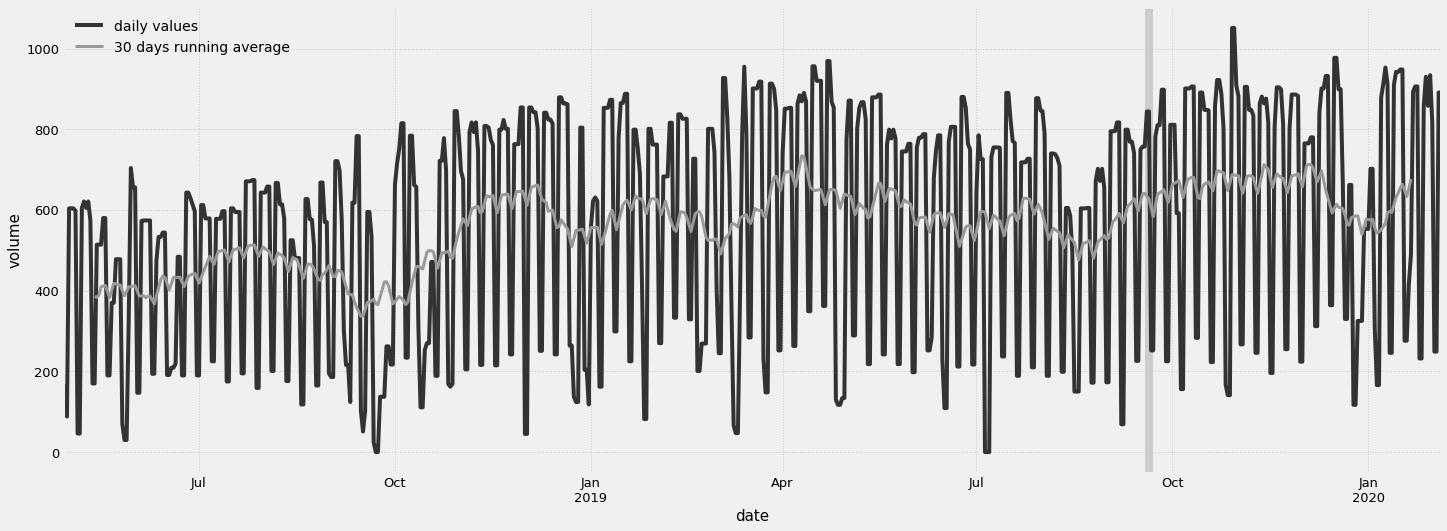

In [84]:
f, ax = plt.subplots(figsize=(22,8))
data.plot(ax=ax, color = '0.2')
data.rolling(window = 30, center = True).mean().plot(ax=ax, ls = '-', lw = 3, color = '0.6')
ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('volume', fontsize=15);

ax.axvline('20/09/2019', color='0.8', lw=8, zorder=-1)

In [85]:
data_train = data[data.index <'2019-09-20']
data_train = data_train.reset_index()
data_train = data_train.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train

,ds,y
0,2018-04-28,88.0
1,2018-04-29,164.0
2,2018-04-30,88.0
3,2018-05-01,604.0
4,2018-05-02,604.0
...,...,...
505,2019-09-15,226.0
506,2019-09-16,750.0
507,2019-09-17,757.0
508,2019-09-18,757.0


In [86]:
data_test = data[data.index > '2019-09-20']
data_test = data_test.reset_index()
data_test = data_test.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test

,ds,y
0,2019-09-21,252.0
1,2019-09-22,252.0
2,2019-09-23,782.0
3,2019-09-24,810.0
4,2019-09-25,810.0
...,...,...
132,2020-01-31,817.0
133,2020-02-01,249.0
134,2020-02-02,249.0
135,2020-02-03,891.0


In [44]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [45]:
m.fit(data_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [47]:
future = m.make_future_dataframe(periods=len(data_test), freq='24H')

In [87]:
future.head()

,ds
0,2018-04-28
1,2018-04-29
2,2018-04-30
3,2018-05-01
4,2018-05-02


In [88]:
future.tail()

,ds
642,2020-01-30
643,2020-01-31
644,2020-02-01
645,2020-02-02
646,2020-02-03


In [50]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-04-28,18.205823,-51.334415,350.081142,8.407232,31.391559,0.0,0.0,0.0,0.0,...,9.028974,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,182.585731
1,2018-04-29,18.227764,-70.299914,356.318816,8.421350,31.453128,0.0,0.0,0.0,0.0,...,8.862787,3.505989,16.125945,-17.545057,-31.478254,-8.436614,0.0,0.0,0.0,179.776561
2,2018-04-30,18.249705,258.694975,682.725523,8.435468,31.468689,0.0,0.0,0.0,0.0,...,31.032142,14.165726,56.559808,4.624297,2.108003,8.496471,0.0,0.0,0.0,584.577140
3,2018-05-01,18.271646,310.444591,730.658789,8.449586,31.445685,0.0,0.0,0.0,0.0,...,34.272492,15.586391,60.674039,7.864648,3.484655,13.369944,0.0,0.0,0.0,644.486484
4,2018-05-02,18.293587,310.792471,728.937684,8.405775,31.428142,0.0,0.0,0.0,0.0,...,34.467249,16.006082,62.627875,8.059405,3.816063,14.204830,0.0,0.0,0.0,648.823203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,2020-01-30,22.617079,324.420045,1041.632226,8.644472,41.547739,0.0,0.0,0.0,0.0,...,35.661902,16.284417,64.837574,9.254058,4.236217,16.935193,0.0,0.0,0.0,829.185130
643,2020-01-31,22.597857,253.064024,933.429392,8.546394,41.632350,0.0,0.0,0.0,0.0,...,31.529365,14.433162,57.009863,5.121520,2.301130,9.203117,0.0,0.0,0.0,735.093931
644,2020-02-01,22.578635,-34.374561,422.453583,8.431045,41.687285,0.0,0.0,0.0,0.0,...,9.028974,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,226.440552
645,2020-02-02,22.559414,-36.873766,400.565164,8.363255,41.754359,0.0,0.0,0.0,0.0,...,8.862787,3.505989,16.125945,-17.545057,-31.478254,-8.436614,0.0,0.0,0.0,222.498700


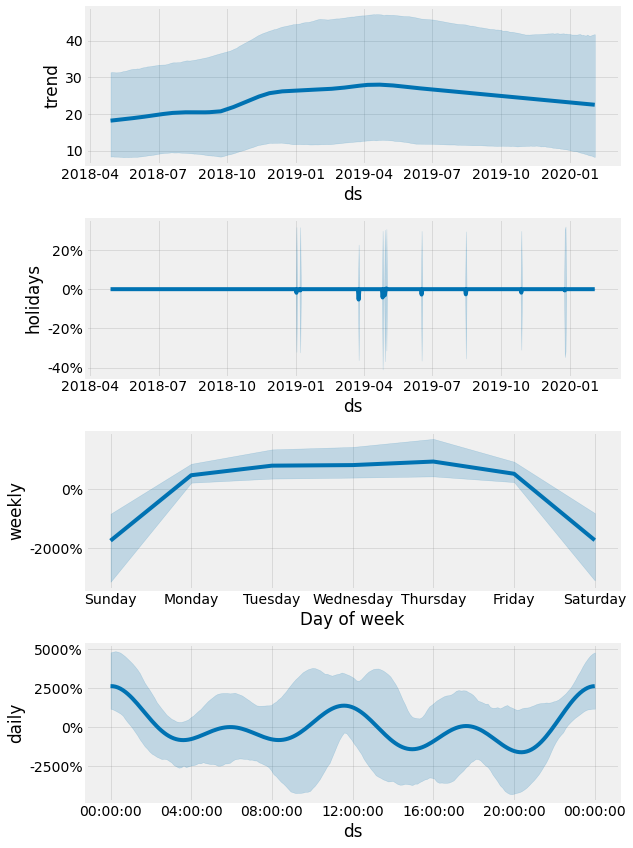

In [89]:
f = m.plot_components(forecast)

In [52]:
verif = utils.make_verif(forecast, data_train, data_test)

In [53]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28,2018-04-28,18.205823,-51.334415,350.081142,8.407232,31.391559,0.0,0.0,0.0,0.0,...,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,182.585731,88.0
2018-04-29,2018-04-29,18.227764,-70.299914,356.318816,8.421350,31.453128,0.0,0.0,0.0,0.0,...,3.505989,16.125945,-17.545057,-31.478254,-8.436614,0.0,0.0,0.0,179.776561,164.0
2018-04-30,2018-04-30,18.249705,258.694975,682.725523,8.435468,31.468689,0.0,0.0,0.0,0.0,...,14.165726,56.559808,4.624297,2.108003,8.496471,0.0,0.0,0.0,584.577140,88.0
2018-05-01,2018-05-01,18.271646,310.444591,730.658789,8.449586,31.445685,0.0,0.0,0.0,0.0,...,15.586391,60.674039,7.864648,3.484655,13.369944,0.0,0.0,0.0,644.486484,604.0
2018-05-02,2018-05-02,18.293587,310.792471,728.937684,8.405775,31.428142,0.0,0.0,0.0,0.0,...,16.006082,62.627875,8.059405,3.816063,14.204830,0.0,0.0,0.0,648.823203,604.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-30,2020-01-30,22.617079,324.420045,1041.632226,8.644472,41.547739,0.0,0.0,0.0,0.0,...,16.284417,64.837574,9.254058,4.236217,16.935193,0.0,0.0,0.0,829.185130,934.0
2020-01-31,2020-01-31,22.597857,253.064024,933.429392,8.546394,41.632350,0.0,0.0,0.0,0.0,...,14.433162,57.009863,5.121520,2.301130,9.203117,0.0,0.0,0.0,735.093931,817.0
2020-02-01,2020-02-01,22.578635,-34.374561,422.453583,8.431045,41.687285,0.0,0.0,0.0,0.0,...,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,226.440552,249.0


# Train Set

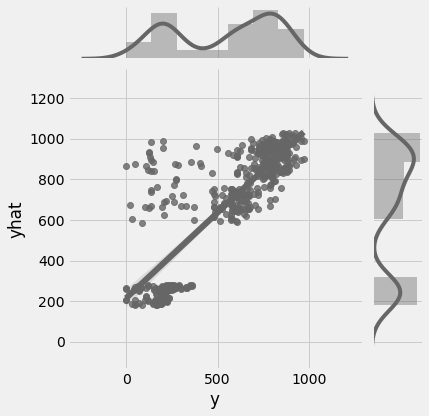

In [54]:
sns.jointplot('y', 'yhat',data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [90]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [99]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.826675
yhat,0.826675,1.000000


In [112]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28,2018-04-28,18.205823,-51.334415,350.081142,8.407232,31.391559,0.0,0.0,0.0,0.0,...,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,182.585731,88.0
2018-04-29,2018-04-29,18.227764,-70.299914,356.318816,8.421350,31.453128,0.0,0.0,0.0,0.0,...,3.505989,16.125945,-17.545057,-31.478254,-8.436614,0.0,0.0,0.0,179.776561,164.0
2018-04-30,2018-04-30,18.249705,258.694975,682.725523,8.435468,31.468689,0.0,0.0,0.0,0.0,...,14.165726,56.559808,4.624297,2.108003,8.496471,0.0,0.0,0.0,584.577140,88.0
2018-05-01,2018-05-01,18.271646,310.444591,730.658789,8.449586,31.445685,0.0,0.0,0.0,0.0,...,15.586391,60.674039,7.864648,3.484655,13.369944,0.0,0.0,0.0,644.486484,604.0
2018-05-02,2018-05-02,18.293587,310.792471,728.937684,8.405775,31.428142,0.0,0.0,0.0,0.0,...,16.006082,62.627875,8.059405,3.816063,14.204830,0.0,0.0,0.0,648.823203,604.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-30,2020-01-30,22.617079,324.420045,1041.632226,8.644472,41.547739,0.0,0.0,0.0,0.0,...,16.284417,64.837574,9.254058,4.236217,16.935193,0.0,0.0,0.0,829.185130,934.0
2020-01-31,2020-01-31,22.597857,253.064024,933.429392,8.546394,41.632350,0.0,0.0,0.0,0.0,...,14.433162,57.009863,5.121520,2.301130,9.203117,0.0,0.0,0.0,735.093931,817.0
2020-02-01,2020-02-01,22.578635,-34.374561,422.453583,8.431045,41.687285,0.0,0.0,0.0,0.0,...,3.781868,16.696858,-17.378870,-31.024508,-8.197643,0.0,0.0,0.0,226.440552,249.0


In [134]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

139.2898778861786

In [93]:
MSE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

45425.14738715586

In [121]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
def MAPE2(y_true, y_pred):  # pylint: disable=missing-docstring
      y_pred = ops.convert_to_tensor(y_pred)
      y_true = math_ops.cast(y_true, y_pred.dtype)
      diff = math_ops.abs((y_true - y_pred) / K.clip(math_ops.abs(y_true), K.epsilon(), None))
      return 100. * K.mean(diff, axis=-1)

In [125]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [120]:
verif.loc[:'2019-09-20', 'y'].values.size

510

In [119]:
verif.loc[:'2019-09-20', 'yhat'].values.size

510

In [126]:
mape_vectorized_v2(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

C:\Users\Nacho\miniconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.6409328382621646

In [133]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

In [135]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

139.2898778861786

In [136]:
MSE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

45425.14738715586

In [138]:
MSLE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

0.6308763019933274

# Test Set

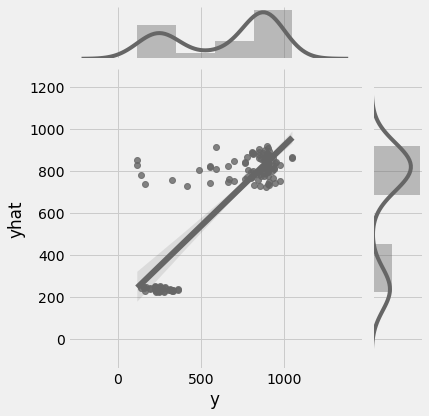

In [139]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')


In [140]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.851736
yhat,0.851736,1.000000


In [149]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

97.4882679185177

Text(0, 0.5, 'NORMALIZED FREQUENCY')

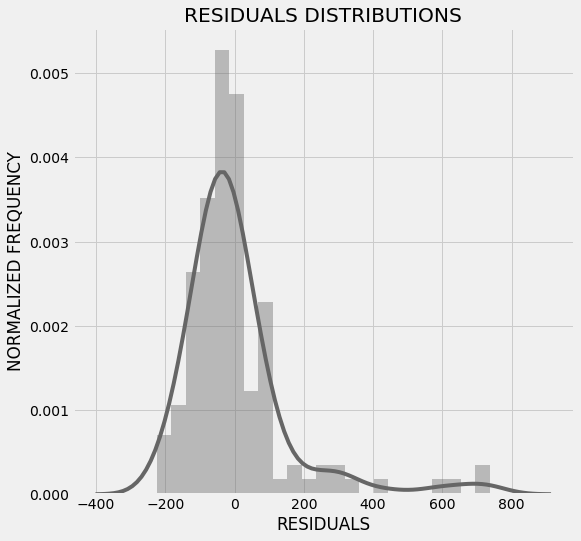

In [142]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [143]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

-2.496826284048196

In [144]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [145]:
residuals.median()

24.482390951296438

In [146]:
residuals.mean()

-3.6398108103894384

In [150]:
MSE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

24754.48564239864

In [154]:
mape_vectorized_v2(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

0.2965368436155957

In [152]:
MSLE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

0.13365345080424795

# Weather data

In [155]:
weather_data = aggregation_functionWeather(1440)

In [156]:
weather_data

,temperature,windSpeed,precipIntensity
timestamp,,,
2018-09-01,28.3,3.6,0.0
2018-09-02,27.9,4.3,0.0
2018-09-03,27.9,4.7,0.0
2018-09-04,27.6,9.5,0.0
2018-09-05,26.6,11.2,0.0
...,...,...,...
2020-02-20,9.8,8.9,0.0
2020-02-21,10.0,10.1,0.0
2020-02-22,9.4,12.7,0.0


In [157]:
weather_data = weather_data.loc[:, ['precipIntensity', 'temperature','windSpeed']]
weather_data

,precipIntensity,temperature,windSpeed
timestamp,,,
2018-09-01,0.0,28.3,3.6
2018-09-02,0.0,27.9,4.3
2018-09-03,0.0,27.9,4.7
2018-09-04,0.0,27.6,9.5
2018-09-05,0.0,26.6,11.2
...,...,...,...
2020-02-20,0.0,9.8,8.9
2020-02-21,0.0,10.0,10.1
2020-02-22,0.0,9.4,12.7


In [158]:
weather_data.corr()

,precipIntensity,temperature,windSpeed
precipIntensity,1.000000,-0.056474,0.167960
temperature,-0.056474,1.000000,-0.041557
windSpeed,0.167960,-0.041557,1.000000


In [159]:
data_all = (data.reset_index()).merge(weather_data, left_on = "timestamp", right_on = "timestamp")
data_all.rename

data_all.set_index('timestamp', inplace = True)

In [160]:
data_all.corr()

,"volume, filtered",precipIntensity,temperature,windSpeed
"volume, filtered",1.000000,0.037292,-0.077308,-0.086441
precipIntensity,0.037292,1.000000,-0.061301,0.171918
temperature,-0.077308,-0.061301,1.000000,-0.022451
windSpeed,-0.086441,0.171918,-0.022451,1.000000


In [161]:
data_all['temperature'] = data_all['temperature'].interpolate(method = 'linear')
data_all['precipIntensity'] = data_all['precipIntensity'].interpolate(method = 'linear')
data_all['windSpeed'] = data_all['windSpeed'].interpolate(method = 'linear')

In [162]:
data_all

,"volume, filtered",precipIntensity,temperature,windSpeed
timestamp,,,,
2018-09-01,186.0,0.0,28.3,3.6
2018-09-02,186.0,0.0,27.9,4.3
2018-09-03,721.0,0.0,27.9,4.7
2018-09-04,721.0,0.0,27.6,9.5
2018-09-05,698.0,0.0,26.6,11.2
...,...,...,...,...
2020-01-31,817.0,0.0,8.4,2.1
2020-02-01,249.0,0.0,12.0,2.5
2020-02-02,249.0,0.0,11.5,1.5


In [163]:
data_train_all = data_all[data_all.index < '2019-09-20']
data_train_all = data_train_all.reset_index()
data_train_all = data_train_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train_all.tail()

,ds,y,precipIntensity,temperature,windSpeed
379,2019-09-15,226.0,0.0,26.0,5.8
380,2019-09-16,750.0,0.0,24.3,4.7
381,2019-09-17,757.0,0.0,24.4,3.3
382,2019-09-18,757.0,0.0,25.1,3.5
383,2019-09-19,844.0,2.0,24.2,8.3


In [164]:
data_test_all = data_all[data_all.index >= '2019-09-20']
data_test_all = data_test_all.reset_index()
data_test_all = data_test_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test_all.tail()

,ds,y,precipIntensity,temperature,windSpeed
133,2020-01-31,817.0,0.0,8.4,2.1
134,2020-02-01,249.0,0.0,12.0,2.5
135,2020-02-02,249.0,0.0,11.5,1.5
136,2020-02-03,891.0,0.0,11.1,1.4
137,2020-02-04,891.0,0.0,13.1,4.2


In [165]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [166]:
m.add_regressor('precipIntensity', prior_scale = 0.5, mode = 'additive')
m.add_regressor('temperature', prior_scale = 0.5, mode = 'additive')
m.add_regressor('windSpeed', prior_scale = 0.5, mode = 'additive')

In [167]:
m.fit(data_train_all)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [168]:
future = m.make_future_dataframe(periods = len(data_test_all), freq = '24H')

In [169]:
future.head()

,ds
0,2018-09-01
1,2018-09-02
2,2018-09-03
3,2018-09-04
4,2018-09-05


In [170]:
future.tail()

,ds
517,2020-01-31
518,2020-02-01
519,2020-02-02
520,2020-02-03
521,2020-02-04


In [171]:
futures = (future).merge(data_all[['precipIntensity', 'temperature', 'windSpeed']], left_on = "ds", right_on = "timestamp")

In [172]:
forecast = m.predict(futures)

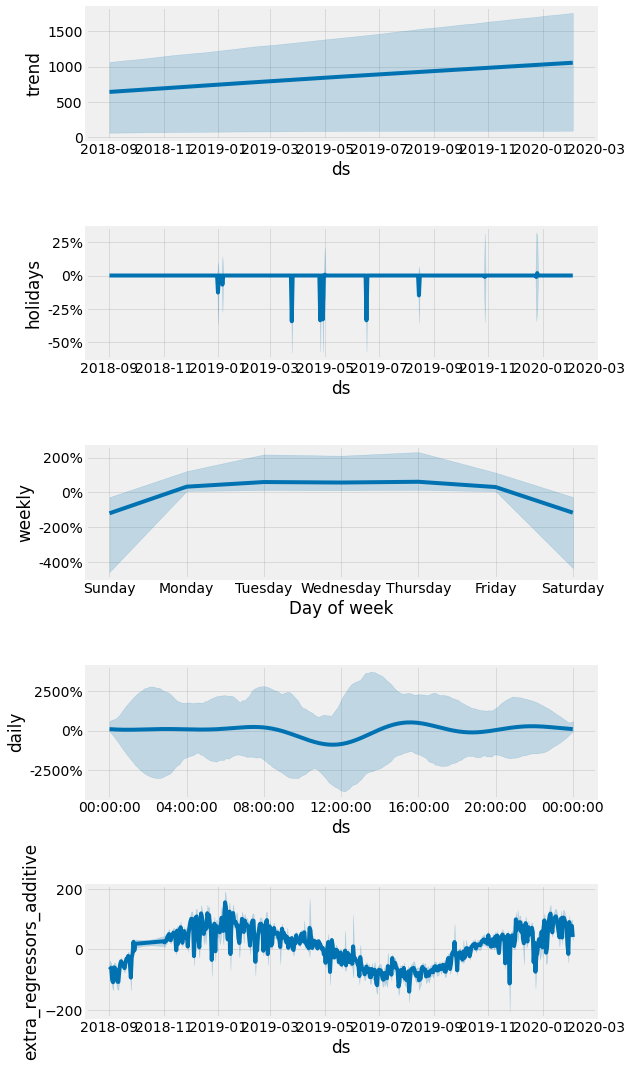

In [173]:
f = m.plot_components(forecast)

In [174]:
verif = utils.make_verif(forecast, data_train_all, data_test_all)

In [175]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-09-01,2018-09-01,641.476047,-104.001363,325.489466,61.626128,1065.234910,0.0,0.0,0.0,0.0,...,-91.757642,-53.886728,-1.171312,-4.352870,-0.271944,16.822202,9.336855,24.611350,389.588093,186.0
2018-09-02,2018-09-02,642.329648,-123.171136,305.582279,61.787776,1066.755681,0.0,0.0,0.0,0.0,...,-88.305606,-51.859443,-1.207245,-4.580830,-0.279273,11.022410,6.117786,16.126093,364.026981,186.0
2018-09-03,2018-09-03,643.183248,251.388070,692.186399,61.985081,1068.276451,0.0,0.0,0.0,0.0,...,-88.305606,-51.859443,0.322405,0.075115,1.213407,7.708243,4.278319,11.277374,1345.122058,721.0
2018-09-04,2018-09-04,644.036849,262.713631,719.677434,62.182386,1069.797222,0.0,0.0,0.0,0.0,...,-85.716579,-50.338979,0.589675,0.130299,2.176341,-32.061760,-46.907247,-17.795292,1481.397771,721.0
2018-09-05,2018-09-05,644.890449,259.982140,706.767918,62.379691,1071.317992,0.0,0.0,0.0,0.0,...,-77.086488,-45.270765,0.560707,0.122172,2.102578,-46.146969,-67.514300,-25.613029,1457.541867,698.0


# Train Set

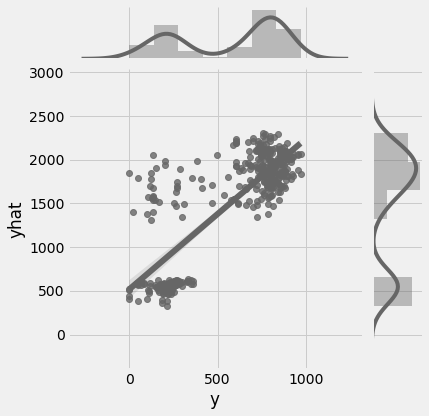

In [176]:
sns.jointplot('y', 'yhat', data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [177]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [178]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.00000,0.81169
yhat,0.81169,1.00000


In [179]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

926.8583905823834

In [180]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

926.8583905823834

In [181]:
MSE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

1039664.0867889614

In [182]:
MSLE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

1.8458325779732838

In [183]:
mape_vectorized_v2(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

C:\Users\Nacho\miniconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


2.4561433420203094

# Test Set

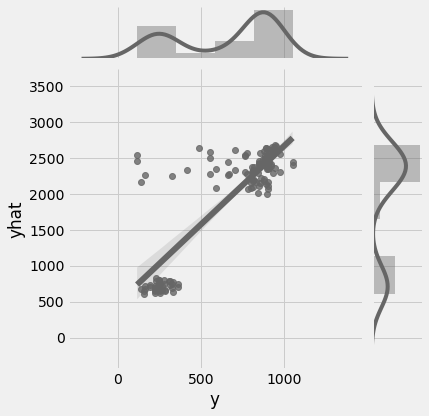

In [184]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')

In [185]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.844357
yhat,0.844357,1.000000


In [186]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

1252.04915625378

Text(0, 0.5, 'NORMALIZED FREQUENCY')

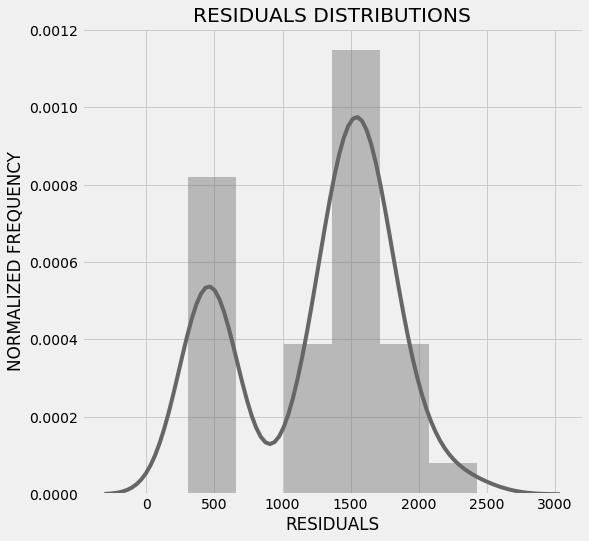

In [187]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [188]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

0.4728806785972381

In [189]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [190]:
residuals.median()

-1460.9411719630532

In [191]:
residuals.mean()

-1252.04915625378

In [193]:
MSE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

1864896.8655142956

In [194]:
MSLE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

1.3606206597436337

In [195]:
mape_vectorized_v2(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

2.379070779325097

In [192]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,temperature_lower,temperature_upper,weekly,weekly_lower,weekly_upper,windSpeed,windSpeed_lower,windSpeed_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-09-01,2018-09-01,641.476047,-104.001363,325.489466,61.626128,1065.234910,0.0,0.0,0.0,0.0,...,-91.757642,-53.886728,-1.171312,-4.352870,-0.271944,16.822202,9.336855,24.611350,389.588093,186.0
2018-09-02,2018-09-02,642.329648,-123.171136,305.582279,61.787776,1066.755681,0.0,0.0,0.0,0.0,...,-88.305606,-51.859443,-1.207245,-4.580830,-0.279273,11.022410,6.117786,16.126093,364.026981,186.0
2018-09-03,2018-09-03,643.183248,251.388070,692.186399,61.985081,1068.276451,0.0,0.0,0.0,0.0,...,-88.305606,-51.859443,0.322405,0.075115,1.213407,7.708243,4.278319,11.277374,1345.122058,721.0
2018-09-04,2018-09-04,644.036849,262.713631,719.677434,62.182386,1069.797222,0.0,0.0,0.0,0.0,...,-85.716579,-50.338979,0.589675,0.130299,2.176341,-32.061760,-46.907247,-17.795292,1481.397771,721.0
2018-09-05,2018-09-05,644.890449,259.982140,706.767918,62.379691,1071.317992,0.0,0.0,0.0,0.0,...,-77.086488,-45.270765,0.560707,0.122172,2.102578,-46.146969,-67.514300,-25.613029,1457.541867,698.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,2020-01-31,1053.216908,690.073800,1197.157276,90.310852,1758.694169,0.0,0.0,0.0,0.0,...,46.970728,79.981164,0.300849,0.066041,1.128440,29.250328,16.234858,42.794044,2374.981574,817.0
2020-02-01,2020-02-01,1053.976112,114.692876,539.313516,90.295875,1760.078756,0.0,0.0,0.0,0.0,...,28.725158,48.912837,-1.171312,-4.352870,-0.271944,25.936161,14.395390,37.945325,797.166566,249.0
2020-02-02,2020-02-02,1054.735315,108.581127,550.598088,90.277237,1761.463342,0.0,0.0,0.0,0.0,...,31.259265,53.227883,-1.207245,-4.580830,-0.279273,34.221578,18.994059,50.067122,771.486984,249.0


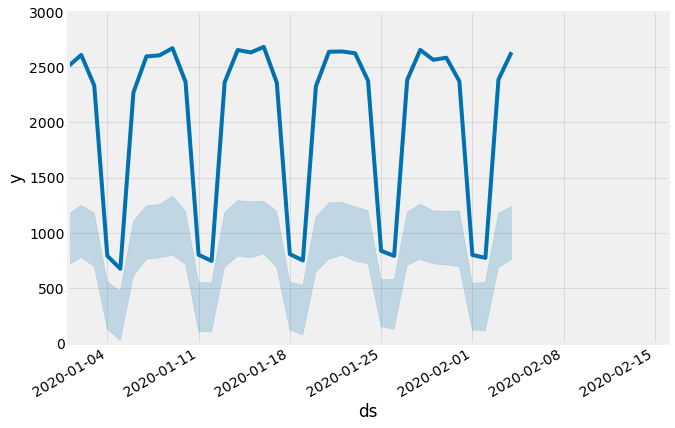

In [199]:
#Figure 118
m.plot(forecast)
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),0,3000])
plt.gcf().autofmt_xdate()

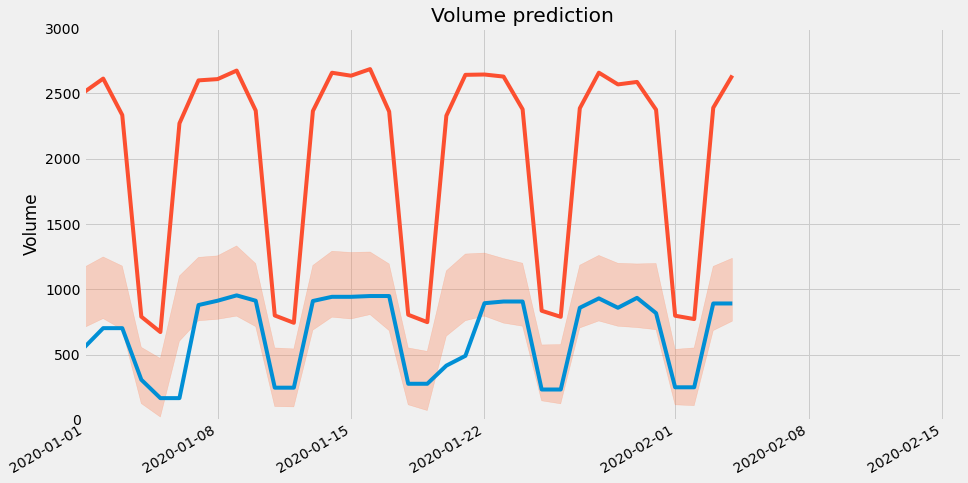

In [200]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(verif.index, verif['y'], label = 'True values')
ax.plot(verif.index, verif['yhat'], label = 'Predicted values')
ax.set_title("Volume prediction")
ax.fill_between(verif.index, verif.loc[:, 'yhat_lower'], verif.loc[:, 'yhat_upper'], color = 'coral', alpha = 0.3)
plt.ylabel("Volume")
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),0,3000])
plt.gcf().autofmt_xdate()

# Correlaciones diarias

In [201]:
corr = verif.loc[:, ['y', 'yhat']].rolling(window = 1000).corr()

In [202]:
corr.index = corr.index.droplevel(1)

Text(0.5, 1.0, 'Correlaciones con media rodante de 1000 períodos')

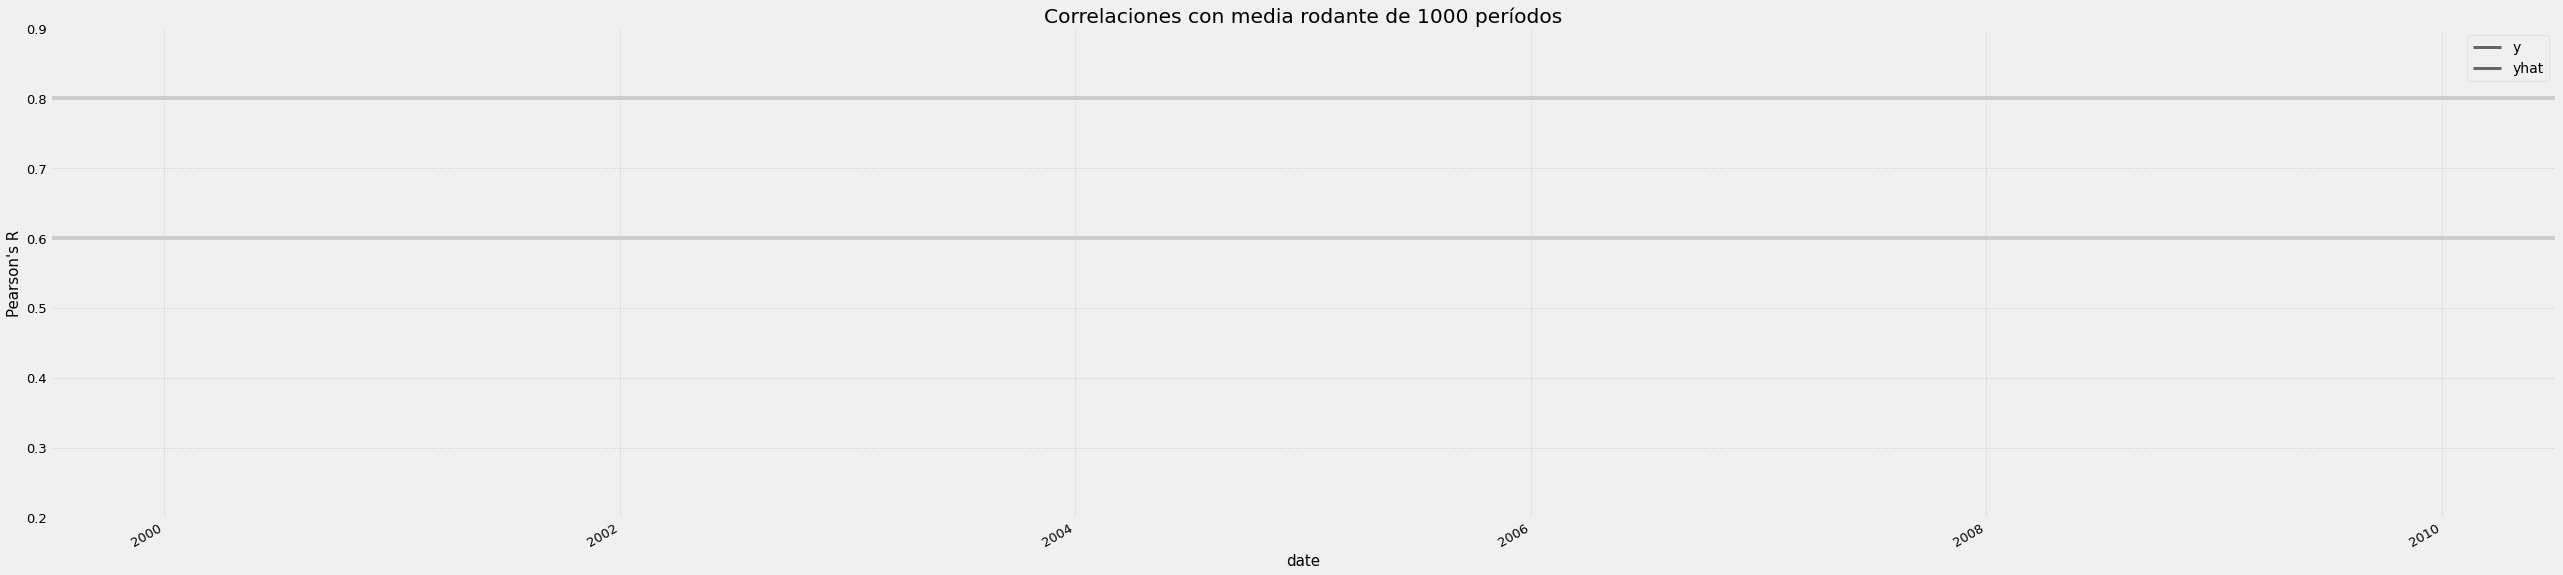

In [203]:
fig, ax = plt.subplots(figsize = (40,10))
corr.plot(ax=ax, lw = 3, color = '0.4')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.grid(ls=':')
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.2, 1., 0.1)); 
ax.set_title('Correlaciones con media rodante de 1000 períodos')


Mucha variabilidad en los datos a lo largo del día, con mucho porcentaje aleatorio que Prophet no es capaz de predecir. 

# Correlaciones por mes

In [204]:
corr_season_train = verif.loc[:'2019-09-20', ['y', 'yhat']].groupby(verif.loc[:'2019-09-20', :].index.month).corr()
corr_season_test = verif.loc['2019-09-20':, ['y', 'yhat']].groupby(verif.loc['2019-09-20':, :].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

Text(0.5, 1.0, 'Correlation per month')

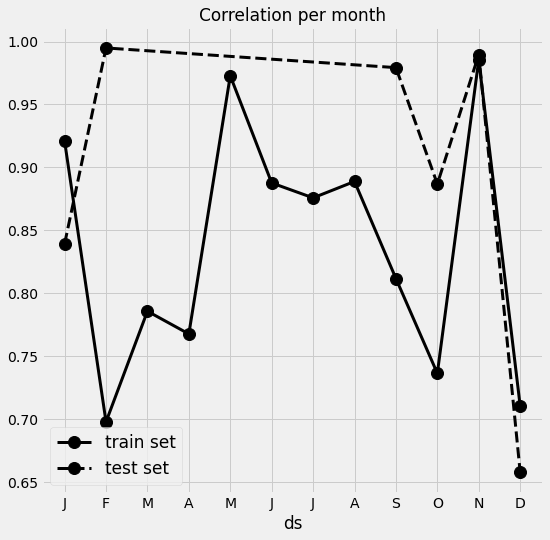

In [205]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_title('Correlation per month', fontsize=17)